Read data from raw_data_dir, models from model dir, and predict the data according to the most current models.  
Plot an example trajectory.

Making predictions...


100%|██████████| 58/58 [01:30<00:00,  1.56s/it]


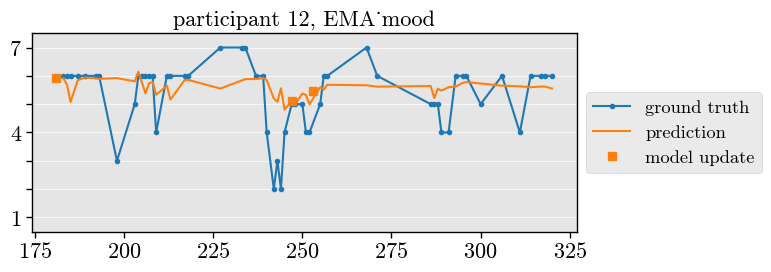

In [8]:
from intervention_effects_utils import EffectsPrediction, ema_names, intervention_names
import data_utils
import custom_rcparams as crc
import matplotlib.pyplot as plt

raw_data_dir = data_utils.join_base_path('reallaborai4u/data_management_MRT2/processed_csv_no_con')
model_dir = data_utils.join_base_path('bptt/results/MRT2_EveryValidDay_Smoothed_best_runs')

font_size = 16

E = EffectsPrediction(raw_data_dir, model_dir, model_for_prediction='current', try_to_load_predictions_file=True)

with plt.rc_context({'font.size':font_size}):
    E.plot_simulated_against_data(12, from_first_prediction=True, features=ema_names[0:1],
                                  data_plot_kwargs={'c':crc.colors.gt},
                                  simulated_plot_kwargs={'marker':'','c':crc.colors.pred}, 
                                  model_change_plot_kwargs={'c':crc.colors.pred},
                                  legend=True)
    plt.tight_layout()
plt.show()

Plot gt versus prediction for all participants and all features

In [ ]:
from intervention_effects_utils import EffectsPrediction, ema_names, intervention_names
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# raw_data_dir = utils.join_base_path('reallaborai4u/data_management/processed_csv_no_con_no_binning')
# model_dir = utils.join_base_path('bptt/results/MRT1_EveryDay02_Smoothed_best_runs')

os.makedirs(f'prediction_plots/{os.path.split(model_dir)[1]}', exist_ok=True)
font_size = 16

# E = EffectsPrediction(raw_data_dir, model_dir, model_for_prediction='current', try_to_load_predictions_file=True)

with plt.rc_context({'font.size':font_size}):
    for ema in tqdm(ema_names):
        axes = E.plot_simulated_against_data(E.participants, from_first_prediction=True, features=ema,
                                             data_plot_kwargs={'c':crc.colors.gt},
                                             simulated_plot_kwargs={'marker':'','c':crc.colors.pred}, 
                                             model_change_plot_kwargs={'c':crc.colors.pred},
                                             legend=False)
        plt.tight_layout()
        plt.savefig(f'prediction_plots/{os.path.split(model_dir)[1]}/{ema}', dpi=200)
        plt.close()

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [03:16<00:00, 13.09s/it]


Plot the prediction error of EMI effects as a function of time.
1. per participant
2. rolling mean over participants

/tmp/ipykernel_2427903/2130060663.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  MAE = pred_effects.groupby(['participant','model_timestep']).mean()


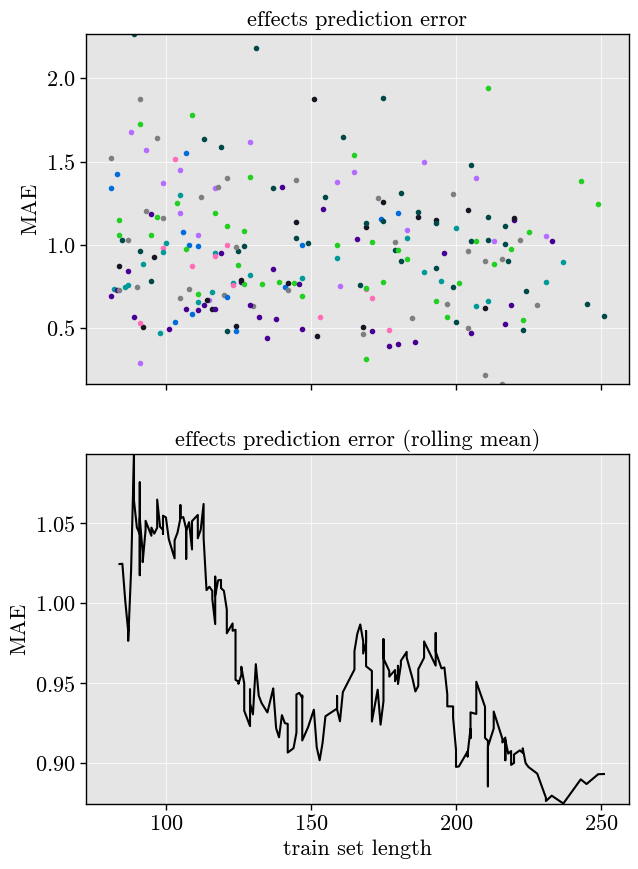

                      sum_sq     df         F    PR(>F)
C(model_timestep)  15.522414  115.0  0.989995  0.521836
Residual           14.861232  109.0       NaN       NaN


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm_api
import statsmodels.formula.api as sm_formula_api
import custom_rcparams as crc

font_size = 16

EMI_only = True
gt_effects = E.calc_effects(use_predicted=False, EMI_only=EMI_only)
pred_effects = E.calc_effects(use_predicted=True, EMI_only=EMI_only)

pred_effects['MAE'] = (pred_effects - gt_effects).abs().mean(axis=1)
pred_effects = pred_effects[pred_effects['model_id'].notna()]
MAE = pred_effects.groupby(['participant','model_timestep']).mean()

with plt.rc_context({'font.size':font_size}):
    fig, axes = plt.subplots(2, 1, figsize=(7,10), sharex=True)
    for p in MAE.index.get_level_values('participant').unique():
        MAE.loc[p, 'MAE'].plot(ax=axes[0], marker='.', linestyle='',
                               title='effects prediction error', xlabel='train set length', ylabel='MAE')
    rollmean = MAE['MAE'].sort_index(level='model_timestep').rolling(50, min_periods=10, center=False).mean()#.droplevel('participant')
    rollmean.loc[MAE['MAE'].notna()].droplevel('participant').plot(
        ax=axes[1], c='k',
        title='effects prediction error (rolling mean)', xlabel='train set length', ylabel='MAE'
    )
plt.show()

formula = f'MAE ~ C(model_timestep)'
lsm = sm_formula_api.ols(formula, data=MAE['MAE'].reset_index()).fit()
anova_table = sm_api.stats.anova_lm(lsm, typ=2)
print(anova_table)

In [ ]:
MAE['MAE'].dropna().index.get_level_values(1).sort_values()

Float64Index([ 81.0,  81.0,  81.0,  82.0,  83.0,  83.0,  84.0,  84.0,  84.0,
               84.0,
              ...
              225.0, 228.0, 231.0, 231.0, 233.0, 237.0, 243.0, 245.0, 249.0,
              251.0],
             dtype='float64', name='model_timestep', length=225)

Make some plots about the correlation between predicted and gt ranks of interventions in terms of effects

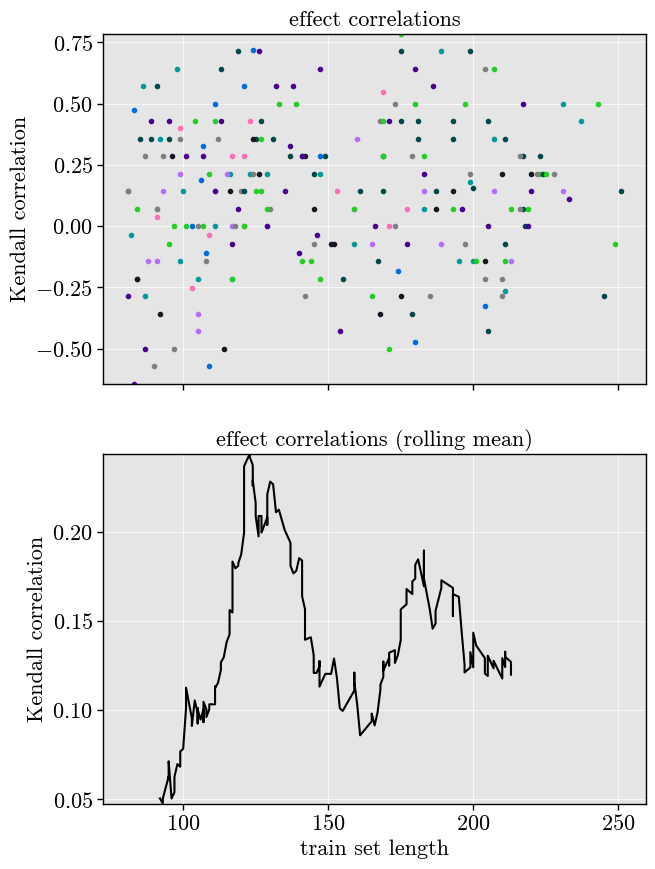

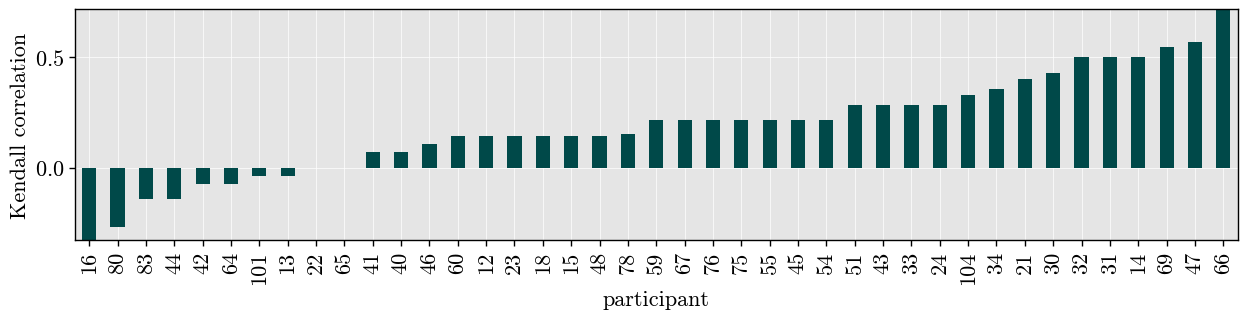

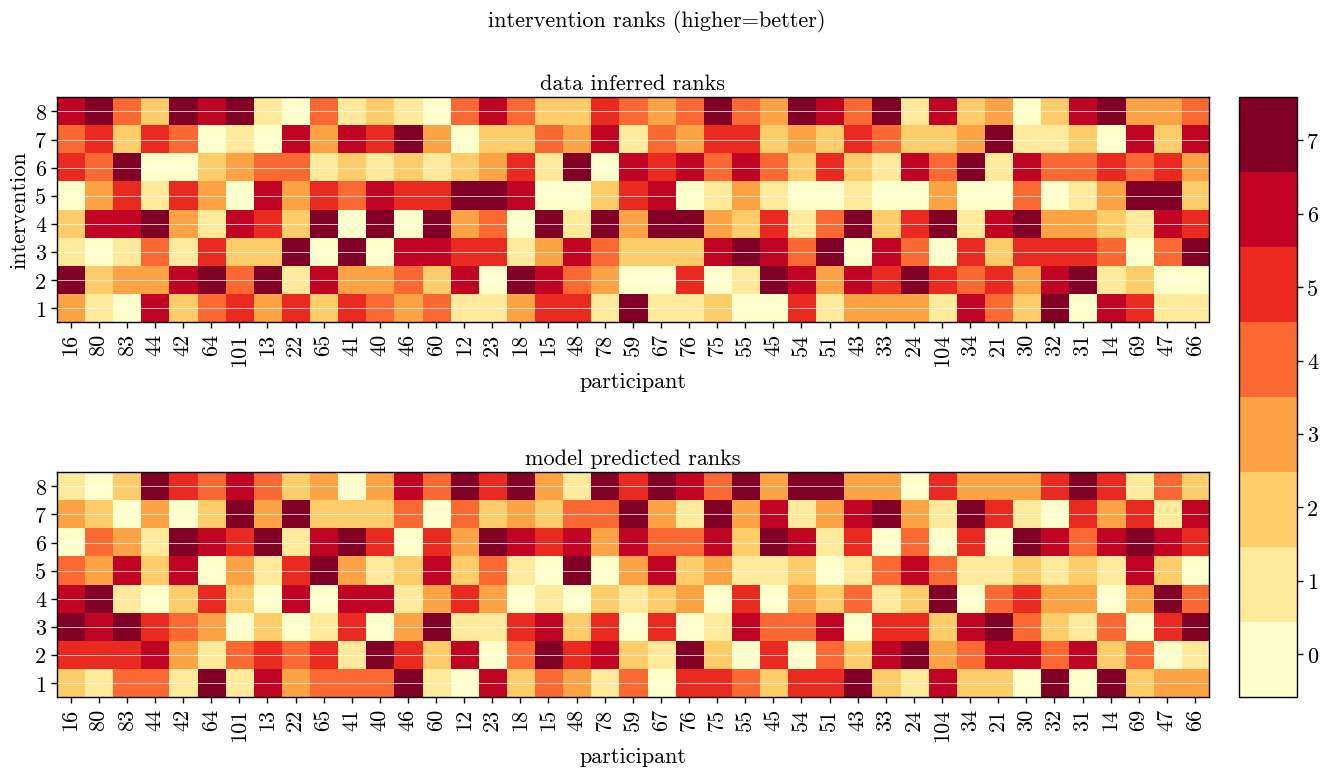

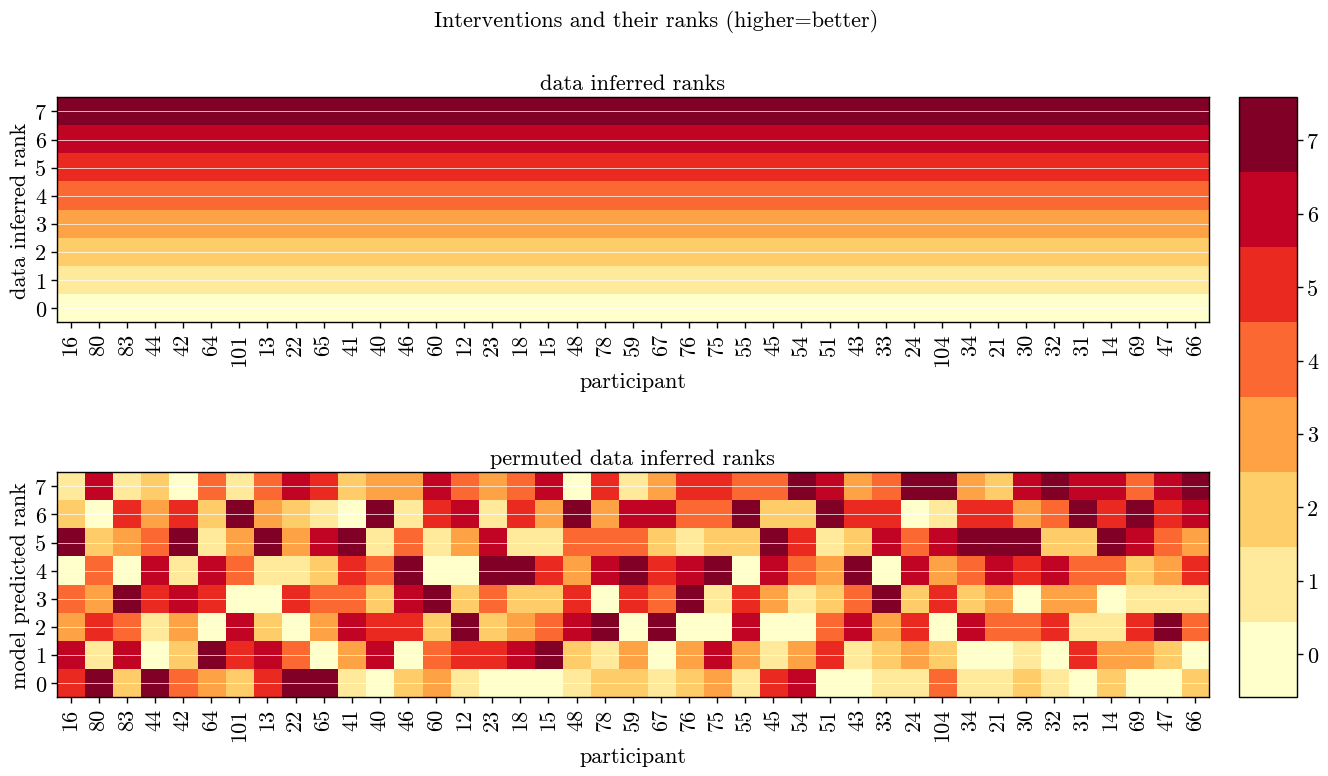

In [ ]:
import sys
sys.path.append('..')
import eval_reallabor_utils
import pandas as pd
import torch as tc
import numpy as np
from tqdm import tqdm
from plotting_utils import discretized_colormap, subplots_with_colorbar
import matplotlib.pyplot as plt
import matplotlib as mpl
import custom_rcparams as crc

predicted_score_file_path = utils.join_base_path(f'bptt/eval_reallabor/predictions/pred_score__{E.data_dir}__{E.model_dir}.csv')
gt_score_file_path = utils.join_base_path(f'bptt/eval_reallabor/predictions/gt_score__{E.data_dir}__{E.model_dir}.csv')

try:
    predicted_score = pd.read_csv(predicted_score_file_path, index_col=[0,1])
    gt_score = pd.read_csv(gt_score_file_path, index_col=[0,1])
except:
    print('Calculate ground truth score and expected predicted score.')
    predicted_score = pd.DataFrame(index=MAE.index, columns=intervention_names, data=0.)
    gt_score = pd.DataFrame(index=MAE.index, columns=intervention_names)

    for (participant, timestep), group in tqdm(pred_effects.groupby(['participant','model_timestep'])):
        model_dir = group['model_id'].unique().item()
        model, _ = eval_reallabor_utils.load_model_and_data(model_dir)
        n_ints = len(intervention_names)
        rest_inputs = model.args['dim_s'] - n_ints
        interventions_matrix = tc.hstack((tc.eye(n_ints), tc.zeros((n_ints, rest_inputs)))) 
        score = tc.zeros(n_ints)
        for n in range(25):
            emas = tc.randint(1, 8, (1, model.args['dim_x']))
            for i, inter in enumerate(interventions_matrix):
                current_inputs = inter.unsqueeze(0)        
                predicted_traj, _ = model.generate_free_trajectory(emas, current_inputs, 2) 
                effect = (predicted_traj[1] - emas).mean()
                if not tc.isnan(effect):
                    predicted_score.loc[(participant, timestep), intervention_names[i]] += effect.item()
        gt_score.loc[(participant, timestep)] = E.aggregate_effects(participant)

    predicted_score /= 800

    predicted_score.to_csv(predicted_score_file_path)
    gt_score.to_csv(gt_score_file_path)


correlations = predicted_score.corrwith(gt_score, axis=1, method='kendall')

font_size = 16

with plt.rc_context():
    mpl.rcParams['font.size'] = font_size
    fig, axes = plt.subplots(2, 1, figsize=(7,10), sharex=True)
    for p in correlations.index.get_level_values('participant').unique():
        correlations.loc[p].plot(ax=axes[0], marker='.', linestyle='',
                                 title='effect correlations', xlabel='train set length', ylabel='Kendall correlation')

    correlations.sort_index(level='model_timestep').rolling(50, center=True).mean().droplevel('participant').plot(
        ax=axes[1], c='k',
        title='effect correlations (rolling mean)', xlabel='train set length', ylabel='Kendall correlation'
    )
    # ax.set_xlim((ax.get_xlim()[0],300))

participants = correlations.groupby('participant').last().sort_values().index

with plt.rc_context():
    mpl.rcParams['font.size'] = font_size
    plt.figure(figsize=(15,3))
    correlations.groupby('participant').last().loc[participants].plot(kind='bar', xlabel='participant', ylabel='Kendall correlation',
                                                                      rot=90)


L = len(intervention_names)
# participants = correlations.index.get_level_values('participant').unique()
cmap = discretized_colormap('YlOrRd', L)
data_ranks = gt_score.groupby('participant').last().apply(lambda x: np.argsort(np.argsort(x)), axis=1)
model_ranks = predicted_score.groupby('participant').last().apply(lambda x: np.argsort(np.argsort(x)), axis=1)

with plt.rc_context({'font.size':font_size}):
    fig, axes = subplots_with_colorbar(data_ranks.loc[participants].T, model_ranks.loc[participants].T, 
                                    nrows=2, share_all=True, cmap=cmap, aspect='auto', axes_pad=1.5, cbar_size='2.5%',
                                    figsize=(16,8), cbar_ticks=np.linspace(0.5, L-1.5, L), cbar_ticklabels=range(L))
    axes[0].set_ylabel('intervention')
    axes[0].set_yticks(range(L), labels=np.arange(L)+1)
    axes[0].set_xlabel('participant')
    axes[0].set_xticks(range(len(model_ranks.index)), labels=participants, rotation=90)
    axes[0].set_title('data inferred ranks')
    axes[1].set_xlabel('participant')
    axes[1].set_xticks(range(len(model_ranks.index)), labels=participants, rotation=90)
    axes[1].set_title('model predicted ranks')
    fig.suptitle('intervention ranks (higher=better)')


    reordered_ranks = np.zeros((len(participants), L))
    for j, p in enumerate(participants):
        reordered_ranks[j] = data_ranks.loc[p].loc[model_ranks.loc[p].sort_values().index].to_numpy()

    fig, ax = subplots_with_colorbar(tc.arange(len(intervention_names)).repeat((len(model_ranks.index), 1)).T, reordered_ranks.T,
                                    nrows=2, share_all=True, cmap=cmap, aspect='auto', axes_pad=1.5, cbar_size='2.5%',
                                    figsize=(16,8), cbar_ticks=np.linspace(0.5, L-1.5, L), cbar_ticklabels=range(L))

    ax[0].set_xlabel('participant')
    ax[0].set_ylabel('data inferred rank')
    ax[0].set_xticks(range(len(participants)), labels=participants, rotation=90)
    ax[0].set_yticks(range(L), labels=np.arange(L))
    ax[0].set_title('data inferred ranks')
    # for pi, p in enumerate(participants):
    #     ordered_intervs = data_ranks.loc[p].argsort().to_numpy() + 1
    #     for ii, i in enumerate(intervention_names):
    #         ax[0].annotate(str(ordered_intervs[ii]), (pi,ii))

    ax[1].set_xlabel('participant')
    ax[1].set_ylabel('model predicted rank')
    ax[1].set_xticks(range(len(participants)), labels=participants, rotation=90)
    ax[1].set_yticks(range(L), labels=np.arange(L))
    ax[1].set_title('permuted data inferred ranks')
    # for pi, p in enumerate(participants):
    #     ordered_intervs = model_ranks.loc[p].argsort().to_numpy() + 1
    #     for ii, i in enumerate(intervention_names):
    #         ax[1].annotate(str(ordered_intervs[ii]), (pi,ii))

    fig.suptitle('Interventions and their ranks (higher=better)')

plt.show()
